## System Models

In [22]:
import autograd.numpy as np
from autograd import jacobian, grad
from scipy.linalg import logm
import matplotlib.pyplot as plt

class VanDerPol(object):
    """
    2D dynamics describing the van der pol osciallator
    """
    def __init__(self, eps=1.0, dt=0.01):
        self.name = "VanDerPol"
        self.eps = eps 
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.num_inputs = 1
        self.reset()

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()
    
    def sample_input(self):
        return np.random.uniform(-3., 3., size=(self.num_inputs,))

    def dynamics(self, x, u):
        xdot = np.array([
            x[1],
            -x[0] + self.eps * (1 - x[0]**2) * x[1] + u[0]
        ])
        return xdot

    def step(self, u):
        k1 = self.dt * self.dynamics(self.state, u)
        k2 = self.dt * self.dynamics(self.state + k1/2., u)
        k3 = self.dt * self.dynamics(self.state + k2/2., u)
        k4 = self.dt * self.dynamics(self.state + k3, u)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()

class LinearSystem(object):
    """
    2D diagonal, linear dynamics (easy easy easy)
    """
    def __init__(self, dt=0.01):
        self.name = "LinearSystem"
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.num_inputs = 1
        self.reset()
        self.evals = [np.exp(dt), np.exp(-1*dt)]

    def reset(self):
        self.state = np.random.uniform(-10., 10., size=(self.num_states,))
        return self.state.copy()
    
    def sample_input(self):
        return np.random.uniform(-3., 3., size=(self.num_inputs,))

    def dynamics(self, x, u):
        xdot = np.array([
            x[0] + x[1],
            -2*x[1] + u[0]
        ])
        return xdot

    def step(self, u):
        k1 = self.dt * self.dynamics(self.state, u)
        k2 = self.dt * self.dynamics(self.state + k1/2., u)
        k3 = self.dt * self.dynamics(self.state + k2/2., u)
        k4 = self.dt * self.dynamics(self.state + k3, u)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()
    
class DiscreteSystem(object):
    """
    discrete 2D dynamics (the simplest system of all time)
    """
    def __init__(self, dt=0.01): 
        self.name = "DiscreteSystem"
        self.dt = dt
        self.num_states = 2
        self.num_inputs = 1
        self.reset()
        self.evals = [1.5, -0.75]

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()
    
    def sample_input(self):
        return np.random.uniform(-3., 3., size=(self.num_inputs,))

    def dynamics(self, x, u):
        x_new = np.array([
            1.5*x[0] + u[0],
            -0.75*x[1]
        ])
        return x_new

    def step(self, u):
        self.state = self.dynamics(self.state, u)
        return self.state.copy()

## Choose model

In [23]:
model = VanDerPol()

## Define dictionaries of observables

In [24]:
class Observables(object):
    
    def __init__(self, choice=0, order=0, cross_terms=False):
        self.choice = choice
        self.order = order
        self.cross_terms = cross_terms

    def z_handmade(self, x, u):
        if self.choice == 1:
            lift_x = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 2:
            lift_x = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1]
            ])

        if self.choice == 3:
            lift_x = np.array([
                x[0],
                x[1],
                x[0]*x[1]
            ])

        if self.choice == 4:
            lift_x = np.array([
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 5:
            lift_x = np.array([
                np.sin(x[0]),
                np.sin(x[1]),
                np.cos(x[0]),
                np.cos(x[1])
            ])

        if self.choice == 6:
            lift_x = np.array([
                x[0],
                x[1],
                np.exp(x[0]),
                np.exp(x[1])
            ])

        #NOTE: since all of our systems have scalar input,
        #we only need a single control observable

        lift = np.append(lift_x, u[0]) 

        return lift

    def z_poly(self, x, u):
        # make polynomial functions up to order n
        polys = {}
        for n in range(self.order):
            polys[n] = lambda a: a**(n+1)
        
        lift_x = np.zeros(2*self.order)
        for m in range(self.order):
            lift_x[2*m] = polys[m](x[0])
            lift_x[1 + 2*m] = polys[m](x[1])

        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = polys[j](x[0])*polys[i](x[1])
                    iter += 1
            lift_x = np.insert(lift_cross_terms, 0, lift_x)

        #append with control observable
        lift = np.append(lift_x, u[0])
        return lift
    
    def higher_derivative(func, order):
        for i in range(order):
            func = grad(func)
        return func

    def z_hermite(self, x, u):
        # make Hermitian polynomials
        polys = {}
        deriv_func = lambda v: np.exp(-0.5*v**2)
        for n in range(self.order):
            deriv_term = self.higher_derivative(deriv_func, n)
            polys[n] = lambda a: (-1.)**n * np.exp(0.5*a**2) * deriv_term(a)

        lift_x = np.zeros(2*self.order)
        for m in range(self.order):
            lift_x[2*m] = polys[m](x[0])
            lift_x[1 + 2*m] = polys[m](x[1])

        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = polys[j](x[0])*polys[i](x[1])
                    iter += 1
            lift_x = np.insert(lift_cross_terms, 0, lift_x)

        #append with control observable
        lift = np.append(lift_x, u[0])
        return lift

## Collect trajectory data and compute EDMD/ResDMD

size of dictionary:  8


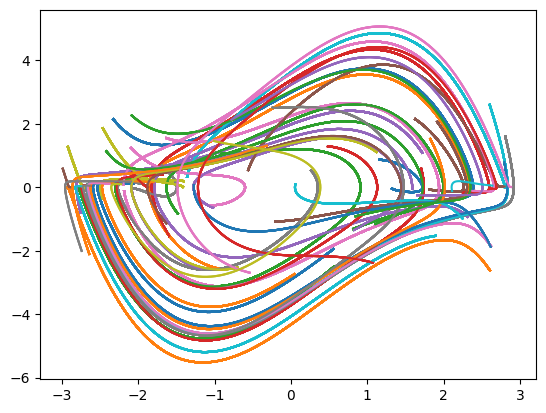

In [25]:
np.random.seed(420) # set the seed for reproducibility 
num_trials = 50 # number of resets
tf = 5
horizon = int(tf/model.dt) # how long we simulate the system for
M = num_trials * horizon # M sized data

traj = np.zeros([2, horizon, num_trials])

### Choose basis functions ###
obs_choice = 4 # if handmade basis is used
order = 3 # if (hermitian) polynomials are used
cross_terms = False

obs = Observables(obs_choice, order, cross_terms)
z = obs.z_handmade # choose which basis functions you want to use

num_obs = len(z(model.reset(), model.sample_input()))
print("size of dictionary: ", num_obs)

# EDMD matrices
A = np.zeros((num_obs, num_obs))
G = np.zeros((num_obs, num_obs))

# ResDMD matrices (only dependent on x observables)
A_x = np.zeros((num_obs-1, num_obs-1))
G_x = np.zeros((num_obs-1, num_obs-1))
L_x = np.zeros((num_obs-1, num_obs-1))

for k in range(num_trials):
    xt = model.reset()
    ut = model.sample_input()
    for t in range(horizon):
        xt_new = model.step(ut)
        ut_new = ut
        traj[:, t, k] = xt_new
 
        # EDMD computation for Koopman operator
        A += np.outer(z(xt_new, ut_new), z(xt, ut))
        G += np.outer(z(xt, ut), z(xt, ut))

        # ResDMD computation for eval errors
        z_xt = np.delete(z(xt, [0.]), -1)
        z_xt_new = np.delete(z(xt_new, [0.]), -1)
        A_x += np.outer(z_xt_new, z_xt)
        G_x += np.outer(z_xt, z_xt)
        L_x += np.outer(z_xt_new, z_xt_new)

    plt.plot(traj[0], traj[1]) # plot trajectories used for
A /= M
G /= M
A_x /= M
G_x /= M
L_x /= M

koopman = np.dot(A, np.linalg.pinv(G))
cont_koopman = logm(koopman)/model.dt

# split apart koopman into A and B matrices
A = koopman[:num_obs-1,:num_obs-1]
B = koopman[:num_obs-1, num_obs-1:]

## Compute the residual, as defined in Matthew Colbrook's ResDMD

In [27]:
evals, evecs = np.linalg.eig(A)
residuals = np.zeros(len(evals))

for i in range(len(evals)):
    evec_mat = np.asmatrix(evecs[:,i]).T
    lam = evals[i]
    numer = evec_mat.H@(L_x - lam*A_x.T - np.conj(lam)*A_x + np.absolute(lam)**2*G_x)@evec_mat
    denom = evec_mat.H@G_x@evec_mat
    residuals[i] = np.sqrt(np.real(numer[0,0])/np.real(denom[0,0]))

for i, eval in enumerate(evals):
    print("|eval|: ", np.absolute(eval), ".......... res: ", residuals[i])

if model.name == "LinearSystem":
    # compute error between estimate eigenvalues and known eigenvalues
    # and compare to residual
    for i, eval in enumerate(evals):
        a = np.abs(eval - model.evals[0])
        b = np.abs(eval - model.evals[1])
        print("Is residual faithful? ", min([a,b]) < residuals[i])

|eval|:  0.6771240533006996 .......... res:  0.6096809723307988
|eval|:  0.22204251598209948 .......... res:  1.4150529519186026
|eval|:  0.13961551167810565 .......... res:  1.3907222126787027
|eval|:  0.13961551167810565 .......... res:  1.3907222126787027
|eval|:  0.03338167016103459 .......... res:  1.8316370424780133
|eval|:  0.054163749955767795 .......... res:  1.6841216813018058
|eval|:  0.054163749955767795 .......... res:  1.6841216813018058
